In [28]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [29]:
df_initial = pd.read_csv("dataframe_nettoye.csv")


In [30]:
df_initial.isna().sum()

LoanNr_ChkDgt             0
Name                     14
City                      0
State                     0
Zip                       0
Bank                      0
BankState                 0
NAICS                     0
ApprovalDate              0
ApprovalFY                0
Term                      0
NoEmp                     0
NewExist                  0
CreateJob                 0
RetainedJob               0
FranchiseCode             0
UrbanRural                0
RevLineCr            277479
LowDoc                    0
ChgOffDate           736465
DisbursementDate       2368
DisbursementGross         0
BalanceGross              0
MIS_Status                0
ChgOffPrinGr              0
GrAppv                    0
SBA_Appv                  0
has_chgoff_date           0
bool_RetainedJob          0
bool_CreateJob            0
Recession                 0
dtype: int64

# On supprime les NaN de RevLineCr

In [31]:
df_initial = df_initial.dropna(subset=["RevLineCr"])


In [32]:
df_initial.isna().sum()
df_initial["RevLineCr"].unique()

array(['N', 'Y'], dtype=object)

# fonctione affichage metriques et auc

In [33]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score


# métriques
def metriques(pipeline, X_test, y_test) :
    y_pred = pipeline.predict(X_test)
    
    # Métriques d'évaluation
    print("Accuracy Score:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    f1_macro = f1_score(y_test, y_pred, average='macro')
    print(f"F1-score macro : {f1_macro}")

    matrice_confusion = confusion_matrix(y_test, y_pred)
    matrice_percentage = matrice_confusion.astype('float') / matrice_confusion.sum(axis=1)[:, np.newaxis] * 100

    class_names = ['CHGOFF', 'PIF']  
    # Affichage de la matrice normalisée  
    plt.figure(figsize=(6, 5))  
    sns.heatmap(matrice_percentage, annot=True, fmt=".2f", cmap='Blues', xticklabels=class_names, yticklabels=class_names)  
    plt.xlabel("Prédictions")  
    plt.ylabel("Vraies valeurs")  
    plt.title("Matrice de Confusion (%)")  
    plt.show()    
    
# courbe AUC
def courbe_AUC(pipeline, X_test, y_test) :
    from sklearn.metrics import roc_curve, auc
    y_pred_proba = pipeline.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()
    
def best_params_to_csv(random_search):
    nom_classifier = random_search.estimator.named_steps[list(random_search.estimator.named_steps.keys())[-1]].__class__.__name__
    params_top = pd.DataFrame([random_search.best_params_])
    params_top.to_csv(f"best_params_{nom_classifier}.csv", index=False)


# pipeline

In [34]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, RobustScaler


df = df_initial.copy()

df["MIS_Status"] = df["MIS_Status"].map({"CHGOFF": 0, "P I F": 1})
df["LowDoc"] = df["LowDoc"].map({"Y" : 1, "N" : 0})

features = ["City", "State", "Zip", "Bank", "BankState", "NAICS", "ApprovalFY", "Term", "NoEmp", "NewExist", "CreateJob", "RetainedJob", "FranchiseCode", "UrbanRural", "LowDoc", "DisbursementGross","GrAppv", "RevLineCr", "SBA_Appv", "bool_RetainedJob",  "bool_CreateJob"]

X = df[features]
y = df['MIS_Status']

num_col = ['ApprovalFY', 'Term', 'NoEmp', 'CreateJob', 'RetainedJob', 'DisbursementGross', 'GrAppv']


numeric_transformer = Pipeline([
    # ('scaler', RobustScaler())])
    ('scaler', StandardScaler())])

def transform_naics(X):
    return X['NAICS'].astype(str).str[:2].astype(int).values.reshape(-1, 1)

def transform_franchise(X):
    return X['FranchiseCode'].apply(lambda x: 1 if x in [0, 1] else 0).values.reshape(-1, 1)

# preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("naics_2_nb", FunctionTransformer(transform_naics), ['NAICS']),
        ("franchise_transform", FunctionTransformer(transform_franchise), ['FranchiseCode']),
        ('num', numeric_transformer, num_col),
    ],
    remainder='drop')

# pipeline
def creer_pipeline(model) :
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    return pipeline


In [35]:
cat_boost_best_params = pd.read_csv("best_params_CatBoostClassifier.csv")

In [36]:
cat_boost_best_params

,classifier__scale_pos_weight,classifier__random_strength,classifier__learning_rate,classifier__l2_leaf_reg,classifier__iterations,classifier__depth,classifier__border_count,classifier__bagging_temperature
0,1,10,0.1,5,800,10,128,0


In [37]:
cat_boost_params = {col.replace('classifier__', ''): val for col, val in cat_boost_best_params.iloc[0].items()}
cat_boost_params["learning_rate"] = 0.12
cat_boost_params

{'scale_pos_weight': 1.0,
 'random_strength': 10.0,
 'learning_rate': 0.12,
 'l2_leaf_reg': 5.0,
 'iterations': 800.0,
 'depth': 10.0,
 'border_count': 128.0,
 'bagging_temperature': 0.0}

In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

In [39]:
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
print("Colonnes catégoriques :", categorical_features)

Colonnes catégoriques : ['City', 'State', 'Bank', 'BankState', 'RevLineCr']


In [40]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report


cat_boost_best = CatBoostClassifier(
    # task_type="GPU",  # Utilisation du GPU nvidia pour accélérer l'entraînement
    random_state=42,
    verbose=100,  # Affichage des logs toutes les 100 itérations
    **cat_boost_params,  # Appliquer tes paramètres optimaux
)

pipeline = creer_pipeline(cat_boost_best)


In [41]:
# Entraînement du modèle sur les données d'entraînement
cat_boost_best.fit(X_train, y_train, cat_features=categorical_features)

0:	learn: 0.5750939	total: 571ms	remaining: 7m 36s
100:	learn: 0.1382000	total: 49.7s	remaining: 5m 43s
200:	learn: 0.1066945	total: 1m 43s	remaining: 5m 9s
300:	learn: 0.0968596	total: 2m 42s	remaining: 4m 29s
400:	learn: 0.0906648	total: 3m 41s	remaining: 3m 40s
500:	learn: 0.0856026	total: 4m 40s	remaining: 2m 47s
600:	learn: 0.0812181	total: 5m 40s	remaining: 1m 52s
700:	learn: 0.0773300	total: 6m 37s	remaining: 56.2s
799:	learn: 0.0738578	total: 7m 35s	remaining: 0us


Accuracy Score: 0.9653525068764175

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.88      0.90     11264
           1       0.97      0.98      0.98     50905

    accuracy                           0.97     62169
   macro avg       0.95      0.93      0.94     62169
weighted avg       0.96      0.97      0.97     62169

F1-score macro : 0.940521504497574


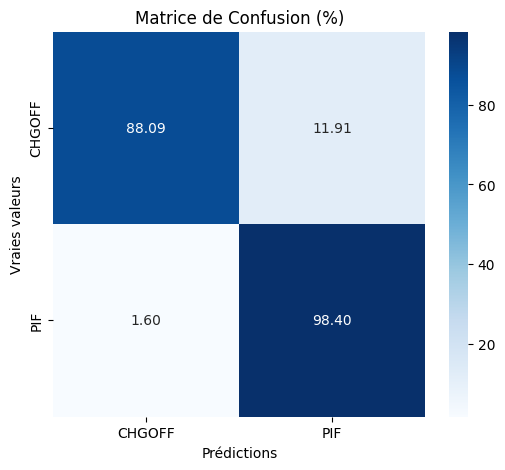

In [42]:
metriques(cat_boost_best, X_test, y_test)

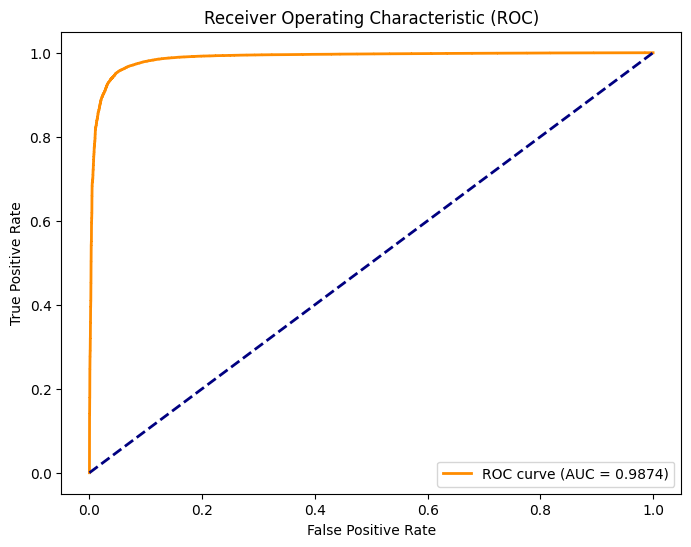

In [43]:
courbe_AUC(cat_boost_best, X_test, y_test)

## features importance

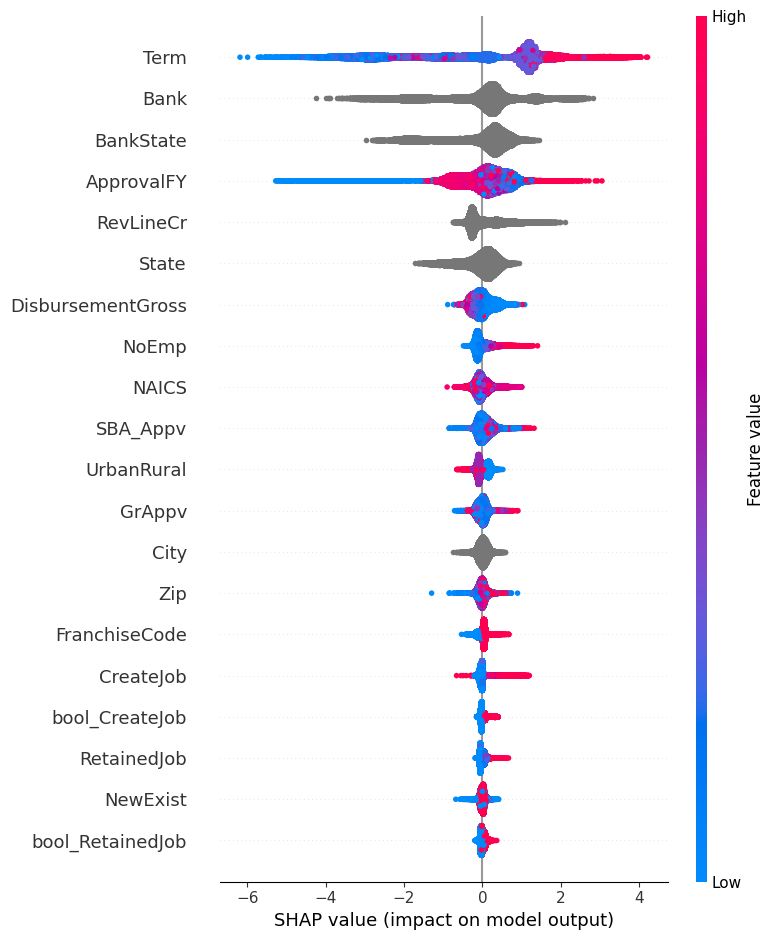

In [44]:
import shap

explainer = shap.TreeExplainer(cat_boost_best)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [45]:
# Récupération des importances des caractéristiques  
feature_importances = cat_boost_best.get_feature_importance()  

# Création d'un DataFrame avec les noms de colonnes  
feature_names = X_train.columns  
importance_df = pd.DataFrame({  
    'Feature': feature_names,  
    'Importance': feature_importances  
})  

# Tri des caractéristiques par importance  
top_features = importance_df.sort_values(by='Importance', ascending=False).head(20)  

# Affichage des 10 variables avec le plus d'impact  
print(top_features)

              Feature  Importance
7                Term   34.915953
6          ApprovalFY   12.627696
3                Bank    9.172352
4           BankState    5.711473
17          RevLineCr    4.593280
1               State    3.805873
18           SBA_Appv    3.574035
5               NAICS    3.460825
2                 Zip    3.237842
0                City    2.981164
15  DisbursementGross    2.968575
16             GrAppv    2.446043
8               NoEmp    2.423657
13         UrbanRural    1.966280
12      FranchiseCode    1.356819
10          CreateJob    1.241988
9            NewExist    1.058074
11        RetainedJob    0.907863
20     bool_CreateJob    0.585990
19   bool_RetainedJob    0.546947


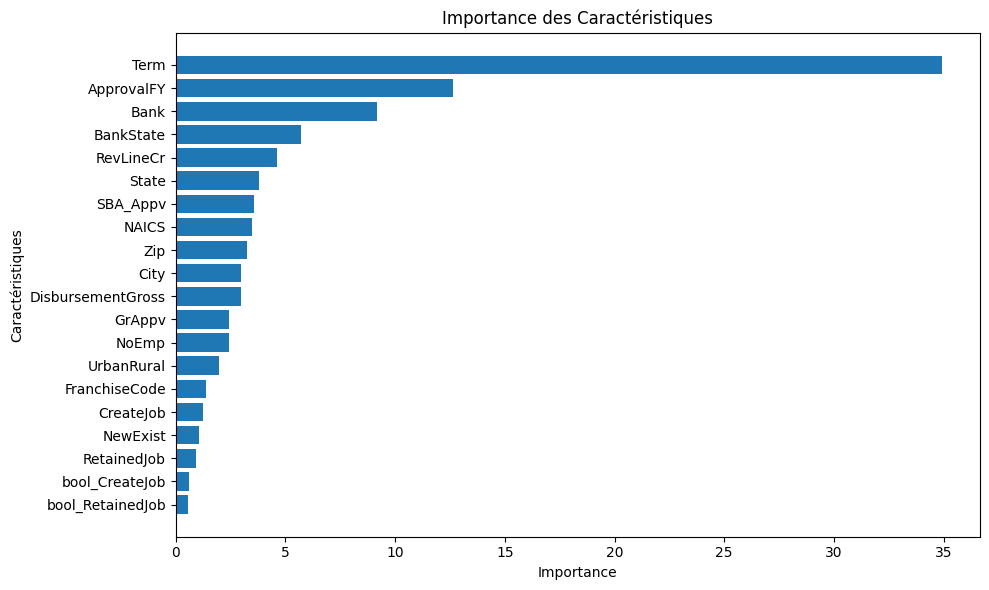

In [46]:
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Caractéristiques')
plt.title('Importance des Caractéristiques')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
